# Part2 Chap.4 ベースライン作成

## 4.1 ベースラインと試行錯誤

### 4.1.1 「ベースライン」と呼ばれる国家雨を最初に作成する

- 分析設計
- データ前処理
- 特徴量作成
- データセット作成
- バリデーション設計
- モデル学習

### 4.1.2 トライ&エラーを繰り返すことを前提とする

train.csvのデータ項目

|#|Data Item|Description|
|:-:|:-|:-|
|1|PassengerID|乗客ID|
|2|Survived|生死（0=死亡、1=生存）|
|3|Pclass|チケットクラス（1=1等客室、2=2等客室、3=3等客室）|
|4|Name|名前|
|5|Sex|性別|
|6|Age|年齢（1歳未満の場合は小数で表現）|
|7|SibSp|同乗している兄弟、配偶者の人数（Sibling=兄弟、Spouse=配偶者）|
|8|Parch|同乗している親、子どもの人数（Parent=親、Child=子供）|
|9|Ticket|チケット番号|
|10|Fare|旅客運賃|
|11|Cabin|キャビン番号|
|12|Embarked|乗船港（C＝シェブール港、Q=クイーンズタウン港、S=サウサンプトン港）|

## 4.2 分析設計

- 目的変数はなにか？
- 目的変数は数値か、カテゴリか？（カテゴリなら2値か多値か？）
- 評価指標（モデルの良し悪しを評価する指標）はなにか？


- 目的変数: survived（「0=死亡」と「1=生存」の2値）
- 評価指標: Accuracy（正解率。判定が正しい割合）

### 4.3 ファイルの読み込み

In [5]:
%pip install pandas
%pip install lightgbm
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


#### ライブラリの読み込み

In [1]:
# ライブラリの読み込み
import numpy as np
import pandas as pd
import os
import pickle
import gc
# 分布確認
# import pandas_profiling as pdp
# 可視化
import matplotlib.pyplot as plt
# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
# モデリング
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# オリジナルで追加
from pprint import pprint
from IPython import display


In [2]:
# ファイルの読み込み
df_train = pd.read_csv("./titanic/train.csv")
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 4.4 データの確認（簡易）

### 4.4.1 レコード数とカラム数の確認

In [3]:
# レコード数とカラム数の確認
print(df_train.shape)
print(f"record_num:  {len(df_train)}")
print(f"column_num:  {len(df_train.columns)}")

(891, 12)
record_num:  891
column_num:  12


### 4.4.2 カラムごとのデータの種類の確認

In [9]:
# データの確認
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [10]:
# Pclassをカテゴリ変数に変換
df_train["Pclass"] = df_train["Pclass"].astype(object)
df_train[["Pclass"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Pclass  891 non-null    object
dtypes: object(1)
memory usage: 7.1+ KB


In [11]:
# データ型をobject型からint型に戻す
df_train["Pclass"] = df_train["Pclass"].astype(np.int64)
df_train[["Pclass"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Pclass  891 non-null    int64
dtypes: int64(1)
memory usage: 7.1 KB


### 4.4.3 欠損値の確認

In [14]:
# 欠損値の確認
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## 4.5 データセットの作成

- 目的変数: Survived
- 説明変数: Pclass, Fare

In [3]:
# データセットの作成
x_train, y_train, id_train = df_train[["Pclass", "Fare"]], df_train[["Survived"]], df_train[["PassengerId"]]
print(x_train.shape, y_train.shape, id_train.shape)

(891, 2) (891, 1) (891, 1)


## 4.6 バリデーション設計

### 4.6.1 「学習データ」と「検証データ」の分割方法

- 推論時と同じケースを学習データから擬似的に生成すること

### 4.6.2 ホールドアウト検証と交差検証（クロスバリデーション）

In [23]:
# ホールドアウト検証
# データセット作成
x_tr, x_va, y_tr, y_va = train_test_split(
    x_train,
    y_train,
    test_size=0.2,
    shuffle=True,
    stratify=y_train,
    random_state=123
)
print(x_tr.shape, y_tr.shape)
print(x_va.shape, y_va.shape)
print(f"{y_train["Survived"].mean():.3f},  {y_tr["Survived"].mean():.3f},  {y_va["Survived"].mean():.3f}")

(712, 2) (712, 1)
(179, 2) (179, 1)
0.384,  0.383,  0.385


In [26]:
# クロスバリデーション
# データセット作成
n_split = 5
cv = list(
    StratifiedKFold(
        n_splits=n_split,
        shuffle=True,
        random_state=123
    ).split(x_train, y_train)
)

for nfold in np.arange(n_split):
    print("-"*20, nfold, "-"*20)
    idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
    x_tr, y_tr = x_train.loc[idx_tr, :], y_train.loc[idx_tr, :]
    x_va, y_va = x_train.loc[idx_va, :], y_train.loc[idx_va, :]
    print(x_tr.shape, y_tr.shape)
    print(x_va.shape, y_va.shape)
    print(f"{y_train["Survived"].mean():.3f},  {y_tr["Survived"].mean():.3f},  {y_va["Survived"].mean():.3f}")

-------------------- 0 --------------------
(712, 2) (712, 1)
(179, 2) (179, 1)
0.384,  0.383,  0.385
-------------------- 1 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
0.384,  0.384,  0.382
-------------------- 2 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
0.384,  0.384,  0.382
-------------------- 3 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
0.384,  0.384,  0.382
-------------------- 4 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
0.384,  0.383,  0.388


## 4.7 モデル学習（勾配ブースティング）

### 4.7.1 ホールドアウト検証の場合

In [27]:
# データセット作成（ホールドアウト検証）
x_tr, x_va, y_tr, y_va = train_test_split(
    x_train,
    y_train,
    test_size=0.2,
    shuffle=True,
    stratify=y_train,
    random_state=123
)
print(x_tr.shape, y_tr.shape)
print(x_va.shape, y_va.shape)
print(f"{y_train["Survived"].mean():.3f},  {y_tr["Survived"].mean():.3f},  {y_va["Survived"].mean():.3f}")

(712, 2) (712, 1)
(179, 2) (179, 1)
0.384,  0.383,  0.385


In [29]:
# モデル学習の実行（ホールドアウト検証）
# ハイパーパラメータ
# LightGBMのearly_stoppingの仕様が変わったので、使用法を調べてみた
# https://qiita.com/c60evaporator/items/2b7a2820d575e212bcf4
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.1,
    "num_leaves": 16,
    "n_estimators": 100000,
    "random_state": 123,
    "importance_type": "gain",
    "early_stopping_rounds": 100,
    "verbose": 10,
}

model = lgb.LGBMClassifier(**params)
model.fit(
    x_tr,
    y_tr,
    eval_set=[(x_tr, y_tr), (x_va, y_va)],
)

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.008427
[LightGBM] [Debug] init for col-wise cost 0.000347 seconds, init for row-wise cost 0.000240 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 2
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGB

LGBMClassifier(early_stopping_rounds=100, importance_type='gain', metric='auc',
               n_estimators=100000, num_leaves=16, objective='binary',
               random_state=123, verbose=10)

In [30]:
# 制度の評価（ホールドアウト検証）
y_tr_pred = model.predict(x_tr)
y_va_pred = model.predict(x_va)
metric_tr = accuracy_score(y_tr, y_tr_pred)
metric_va = accuracy_score(y_va, y_va_pred)
print(f"[accuracy] tr: {metric_tr:.2f},  va: {metric_va:.2f}")

[accuracy] tr: 0.75,  va: 0.73


In [31]:
# 説明変数の重要度（ホールドアウト検証）
imp = pd.DataFrame({
    "col": x_train.columns,
    "imp": model.feature_importances_
})
imp.sort_values("imp", ascending=False, ignore_index=True)

,col,imp
0,Fare,903.440373
1,Pclass,229.457186


### 4.7.2 クロスバリデーションの場合

In [39]:
# モデル学習の実行（クロスバリデーション）
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.1,
    "num_leaves": 16,
    "n_estimators": 100000,
    "random_state": 123,
    "importance_type": "gain",
    "early_stopping_rounds": 100,
    "verbose": 10,
}

metrics = list()
imp = pd.DataFrame()

# データセット作成
n_splits = 5
cv = list(StratifiedKFold(n_splits=n_split, shuffle=True, random_state=123).split(x_train, y_train))

for nfold in np.arange(n_split):
    print("-"*20, nfold, "-"*20)
    idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
    x_tr, y_tr = x_train.loc[idx_tr, :], y_train.loc[idx_tr, :]
    x_va, y_va = x_train.loc[idx_va, :], y_train.loc[idx_va, :]
    print(x_tr.shape, y_tr.shape)
    print(x_va.shape, y_va.shape)
    print(f"{y_train["Survived"].mean():.3f},  {y_tr["Survived"].mean():.3f},  {y_va["Survived"].mean():.3f}")

    # モデル学習
    model = lgb.LGBMClassifier(**params)
    model.fit(
        x_tr,
        y_tr,
        eval_set=[(x_tr, y_tr), (x_va, y_va)],
    )

    # 制度の評価
    y_tr_pred = model.predict(x_tr)
    y_va_pred = model.predict(x_va)
    metric_tr = accuracy_score(y_tr, y_tr_pred)
    metric_va = accuracy_score(y_va, y_va_pred)
    print(f"[accuracy] tr: {metric_tr:.2f},  va: {metric_va:.2f}")
    metrics.append([nfold, metric_tr, metric_va])

    # 説明変数の重要度（ホールドアウト検証）
    _imp = pd.DataFrame({
        "col": x_train.columns,
        "imp": model.feature_importances_
    })
    imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

print("-"*20, "result", "-"*20)
metrics = np.array(metrics)
print(metrics)

print(f"[cv ] tr: {metrics[:, 1].mean():.2f}+-{metrics[:, 1].std()},  va: {metrics[:, 2].mean():.2f}+-{metrics[:, 2].std():.2f}")

print("Done.")

-------------------- 0 --------------------
(712, 2) (712, 1)
(179, 2) (179, 1)
0.384,  0.383,  0.385
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.008427
[LightGBM] [Debug] init for col-wise cost 0.000001 seconds, init for row-wise cost 0.000052 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 123
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 2
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Inf

In [40]:
# 説明変数の重要度
imp = imp.groupby("col")["imp"].aggregate(["mean", "std"])
imp.columns = ["imp", "imp_std"]
imp = imp.reset_index(drop=False)
imp.sort_values("imp", ascending=False, ignore_index=True)

,col,imp,imp_std
0,Fare,679.390270,356.992896
1,Pclass,291.704529,138.843896


### 4.7.3 ベースラインの評価

In [5]:
# ベースライン検証用データ作成
x_tr, x_va2, y_tr, y_va2 = train_test_split(
    x_train,
    y_train,
    test_size=0.2,
    shuffle=True,
    stratify=y_train,
    random_state=123
)
print(x_tr.shape, y_tr.shape)
print(x_va2.shape, y_va2.shape)

(712, 2) (712, 1)
(179, 2) (179, 1)


In [6]:
# 学習データと検証データの分割（ホールドアウト検証）
x_tr1, x_va1, y_tr1, y_va1 = train_test_split(
    x_tr,
    y_tr,
    test_size=0.2,
    shuffle=True,
    stratify=y_tr,
    random_state=789
)
print(x_tr1.shape, y_tr1.shape)
print(x_va1.shape, y_va1.shape)

(569, 2) (569, 1)
(143, 2) (143, 1)


In [7]:
# モデル学習（ホールドアウト検証）
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.1,
    "num_leaves": 16,
    "n_estimators": 100000,
    "random_state": 123,
    "importance_type": "gain",
    "early_stopping_rounds": 100,
    "verbose": 10,
}
model = lgb.LGBMClassifier(**params)
model.fit(
    x_tr1,
    y_tr1,
    eval_set=[(x_tr1, y_tr1), (x_va1, y_va1)],
)

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Number of positive: 218, number of negative: 351
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.008787
[LightGBM] [Debug] init for col-wise cost 0.000302 seconds, init for row-wise cost 0.000165 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 2
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383128 -> initscore=-0.476291
[LightGBM] [Info] Start training from score -0.476291
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 

LGBMClassifier(early_stopping_rounds=100, importance_type='gain', metric='auc',
               n_estimators=100000, num_leaves=16, objective='binary',
               random_state=123, verbose=10)

In [8]:
# 検証データとベースライン検証用データの予測値算出
y_va1_pred = model.predict(x_va1)
y_va2_pred = model.predict(x_va2)

In [9]:
# モデル精度の比較
print(f"[検証データ] acc:  {accuracy_score(y_va1, y_va1_pred):.4f}")
print(f"[ベースライン検証用データ] acc:  {accuracy_score(y_va2, y_va2_pred):.4f}")

[検証データ] acc:  0.7133
[ベースライン検証用データ] acc:  0.7095


In [10]:
# 誤差分布の比較
# 混合行列（confusion matrix）の比較
print("検証データ")
print(confusion_matrix(y_va1, y_va1_pred))
print(confusion_matrix(y_va1, y_va1_pred, normalize="all"))

print("ベースライン検証用データ")
print(confusion_matrix(y_va2, y_va2_pred))
print(confusion_matrix(y_va2, y_va2_pred, normalize="all"))

検証データ
[[76 12]
 [29 26]]
[[0.53146853 0.08391608]
 [0.2027972  0.18181818]]
ベースライン検証用データ
[[92 18]
 [34 35]]
[[0.51396648 0.10055866]
 [0.18994413 0.19553073]]


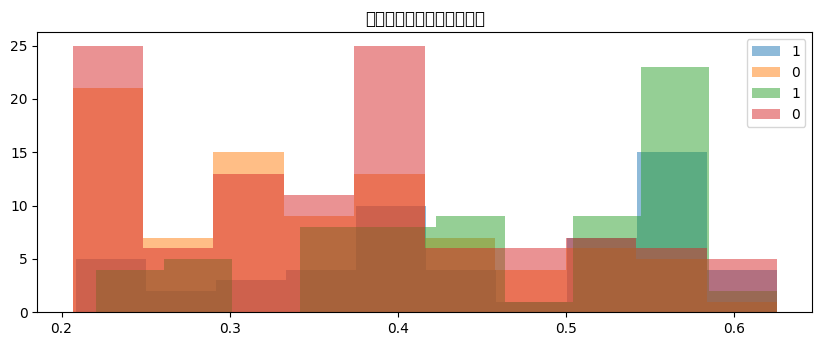

In [11]:
# 予測値の分布の比較
y_va1_pred_prob = model.predict_proba(x_va1)[:, 1]
y_va2_pred_prob = model.predict_proba(x_va2)[:, 1]

# 確率値をヒストグラムで可視化
fig = plt.figure(figsize=(10, 8))
# 検証データ
fig.add_subplot(2, 1, 1)
plt.title("検証データ")
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1) == 1], bins=10, alpha=0.5, label="1")
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1) == 0], bins=10, alpha=0.5, label="0")
plt.grid()
plt.legend()
# ベースライン検証用データ
plt.title("ベースライン検証用データ")
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1) == 1], bins=10, alpha=0.5, label="1")
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1) == 0], bins=10, alpha=0.5, label="0")
plt.grid()
plt.legend()

## 4.8 モデル推論

### 4.8.1 推論用データセット作成